# Set up the enviroment + load the data 

In [2]:
%matplotlib notebook

# importing packages
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# importing training data

#train = pd.read_csv("we_data/train.csv")       # Shape:  (2430981, 25) 
#test = pd.read_csv("we_data/test.csv")         # Shape:  (303375, 22) 
data = pd.read_csv("we_data/validation.csv")    # Shape:  (303925, 25) 

### Understand the data 

In [5]:
print('Shape: ', data.shape,'\n')
print('Columns: \n', data.columns,'\n')
print('Sample of data: \n')
data.head()

Shape:  (303925, 25) 

Columns: 
 Index(['click', 'weekday', 'hour', 'bidid', 'userid', 'useragent', 'IP',
       'region', 'city', 'adexchange', 'domain', 'url', 'urlid', 'slotid',
       'slotwidth', 'slotheight', 'slotvisibility', 'slotformat', 'slotprice',
       'creative', 'bidprice', 'payprice', 'keypage', 'advertiser', 'usertag'],
      dtype='object') 

Sample of data: 



,click,weekday,hour,bidid,userid,useragent,IP,region,city,adexchange,...,slotheight,slotvisibility,slotformat,slotprice,creative,bidprice,payprice,keypage,advertiser,usertag
0,0,4,20,bbcb813b6166538503d8b33a5602d7d72f6019dc,663169f66491c98c69f1f94a5c48fa34aa9fe06f,windows_ie,211.144.203.*,79,79,1.0,...,600,2,1,0,cb7c76e7784031272e37af8e7e9b062c,300,23,bebefa5efe83beee17a3d245e7c5085b,1458,"13866,10111"
1,0,1,21,5a07316c49477cb5d9b4d5aa39c27d6c3be7f92d,a23f0cfab6592c137f796e68fa752fceba08bb1b,windows_chrome,58.247.250.*,79,79,1.0,...,90,0,1,0,c938195f9e404b4f38c7e71bf50263e5,238,75,a3becb967c015e9acb5e72f22b100ef8,3476,"10075,10057,10024,10052,10083,10063,10006,10110"
2,0,4,8,f6ece71dae81d6b16bfb24ad6dd5611472d4c673,5105a013ea54a9706146033e6a138d5234a3803e,windows_ie,117.12.111.*,2,2,2.0,...,250,2,0,5,911b2d84826786018761e8c0b0a3a60c,238,65,d29e59bf0f7f8243858b8183f14d4412,3358,"13866,10024,10059,10063,13776,10083,10006,10111"
3,0,5,15,b4d5c57c9b38ff5a12954fa01e11931b4e6bfbbb,577e9a768ce17e73c61ba7022db927f9ee761830,windows_chrome,61.187.224.*,201,205,2.0,...,280,2,0,5,dc0998c10f8f0b623b5d949e8272e4c7,238,6,d29e59bf0f7f8243858b8183f14d4412,3358,"13866,10057,10006,10063,10110"
4,0,1,18,0899bf144249458ea9c89188473694bf44c7ca15,e4bf79c562745d671b19f2edf7fda89c2e25987f,windows_chrome,117.41.145.*,134,135,2.0,...,200,1,0,5,23485fcd23122d755d38f8c89d46ca56,249,5,7e0e909ea89f707bc20f9585c9072081,3476,"10006,10063,13776,10110"


###  create global variables

In [6]:
limited_budget = 6250*1000

min_bid = min(data['bidprice'])
max_bid = max(data['bidprice'])
print(min_bid, max_bid)

min_pay = min(data['payprice'])
max_pay = max(data['payprice'])
print(min_pay, max_pay)

def binary_search(arr, val):
    # returns index
    low, high = 0, len(arr) - 1
    
    while low < high:
        
        mid = int((low+high)/2)
        
        if arr[mid] < val:
            low = mid + 1
        else:
            high = mid
    
    return low

227 300
0 300


In [8]:
pred = pd.read_csv('pctr_validation_8707.csv')
avgCTR = (data.click.sum() / len(data))

#merge prediction
data_new = data.merge(pred)

# rename column label
columns = list(data_new.columns)
columns[-1] = 'pCTR'
data_new.columns = columns

print(data_new.columns)
data_new.head()

,bidid,0
0,bbcb813b6166538503d8b33a5602d7d72f6019dc,0.000178
1,5a07316c49477cb5d9b4d5aa39c27d6c3be7f92d,0.000123
2,f6ece71dae81d6b16bfb24ad6dd5611472d4c673,0.000153
3,b4d5c57c9b38ff5a12954fa01e11931b4e6bfbbb,0.000110
4,0899bf144249458ea9c89188473694bf44c7ca15,0.000140


# Create the binary agent environment 

In [11]:
def create_bids(basebids, dat):
    
    bids = []
    for b in basebids:
        bids.append(b * dat.pCTR / avgCTR)
    
    return np.array(bids).T  # dim n_bids x n_agents

In [12]:
def bi_agent(dat, act1, act2):
    
    n = dat.shape[0]
    n_agents = 2
    
    n_act1 = len(act1)
    n_act2 = len(act2)
    
    results = []    
    payoffs = [[0]*n_act2 for _ in range(n_act1)]
    
    for ind1, b1 in enumerate(act1):
        for ind2, b2 in enumerate(act2):
            
            basebids = [b1, b2]
            bids = create_bids(basebids, dat)
            
            # create mask:
            mask = np.zeros((n, n_agents))

            ind_max_bid1 = np.argmax(bids, axis=1)
            max_bid1 = np.max(bids, axis=1)

            bids[list(range(n)), ind_max_bid1] = 0
            max_bid2 = np.max(bids, axis=1)

            someone_wins = dat.payprice <= max_bid1

            mask[list(range(n)), ind_max_bid1] = someone_wins
            payprice = np.maximum(max_bid2, dat.payprice)

            n_clk = []

            for agent in range(n_agents):
                end = binary_search(np.cumsum(payprice*mask[:,agent]), limited_budget)
                n_clk.append(np.sum((dat.click*mask[:,agent])[:end]))

            payoffs[ind1][ind2] = n_clk
            
    return payoffs

### run experiment 1

In [48]:
n_experiments = 1
exp_rnd = []

grids = 14
space1 = 15
space2 = 15
ini1 = 0
ini2 = 0
act1 = list(range(ini1, ini1 + grids*space1, space1))
act2 = list(range(ini2, ini2 + grids*space2, space2))

#act1 = [110, 120, 130]
#act2 = [0, 5, 10]

for i in tqdm(range(n_experiments)):
    #print(f'{i} / {n_experiments}')
    data_rand = data_new.sample(frac=1).reset_index(drop=True)
    exp_rnd.append(bi_agent(data_rand, act1, act2))

exp_rnd = np.array(exp_rnd)
exp_avg = np.mean(exp_rnd, axis = 0)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:46<00:00, 46.49s/it]


In [49]:
payoffs_agent1 = np.round(exp_avg[:,:,0]).astype(int)
payoffs_agent2 = np.round(exp_avg[:,:,1]).astype(int)
print(payoffs_agent2)

[[  0  50  76  89 113 122 134 144 151 155 158 161 142 126]
 [  0   0  76  89 113 122 134 144 151 155 158 154 139 121]
 [  0   0   0  89 113 122 134 144 151 155 158 141 122 116]
 [  0   0   0   0 113 122 134 144 151 155 140 123 115 108]
 [  0   0   0   0   0 122 134 144 151 135 118 112 105 102]
 [  0   0   0   0   0   0 134 137 129 112 109 103  97  95]
 [  0   0   0   0   0   0   0 111 107 101  97  95  89  86]
 [  0   0   0   0   0   0   0   0  95  92  88  83  80  76]
 [  0   0   0   0   0   0   0   0   0  81  77  74  72  70]
 [  0   0   0   0   0   0   0   0   0   0  69  67  67  69]
 [  0   0   0   0   0   0   0   0   0   0   0  66  64  66]
 [  0   0   0   0   0   0   0   0   0   0   0   0  60  60]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  57]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0]]


<IPython.core.display.Javascript object>


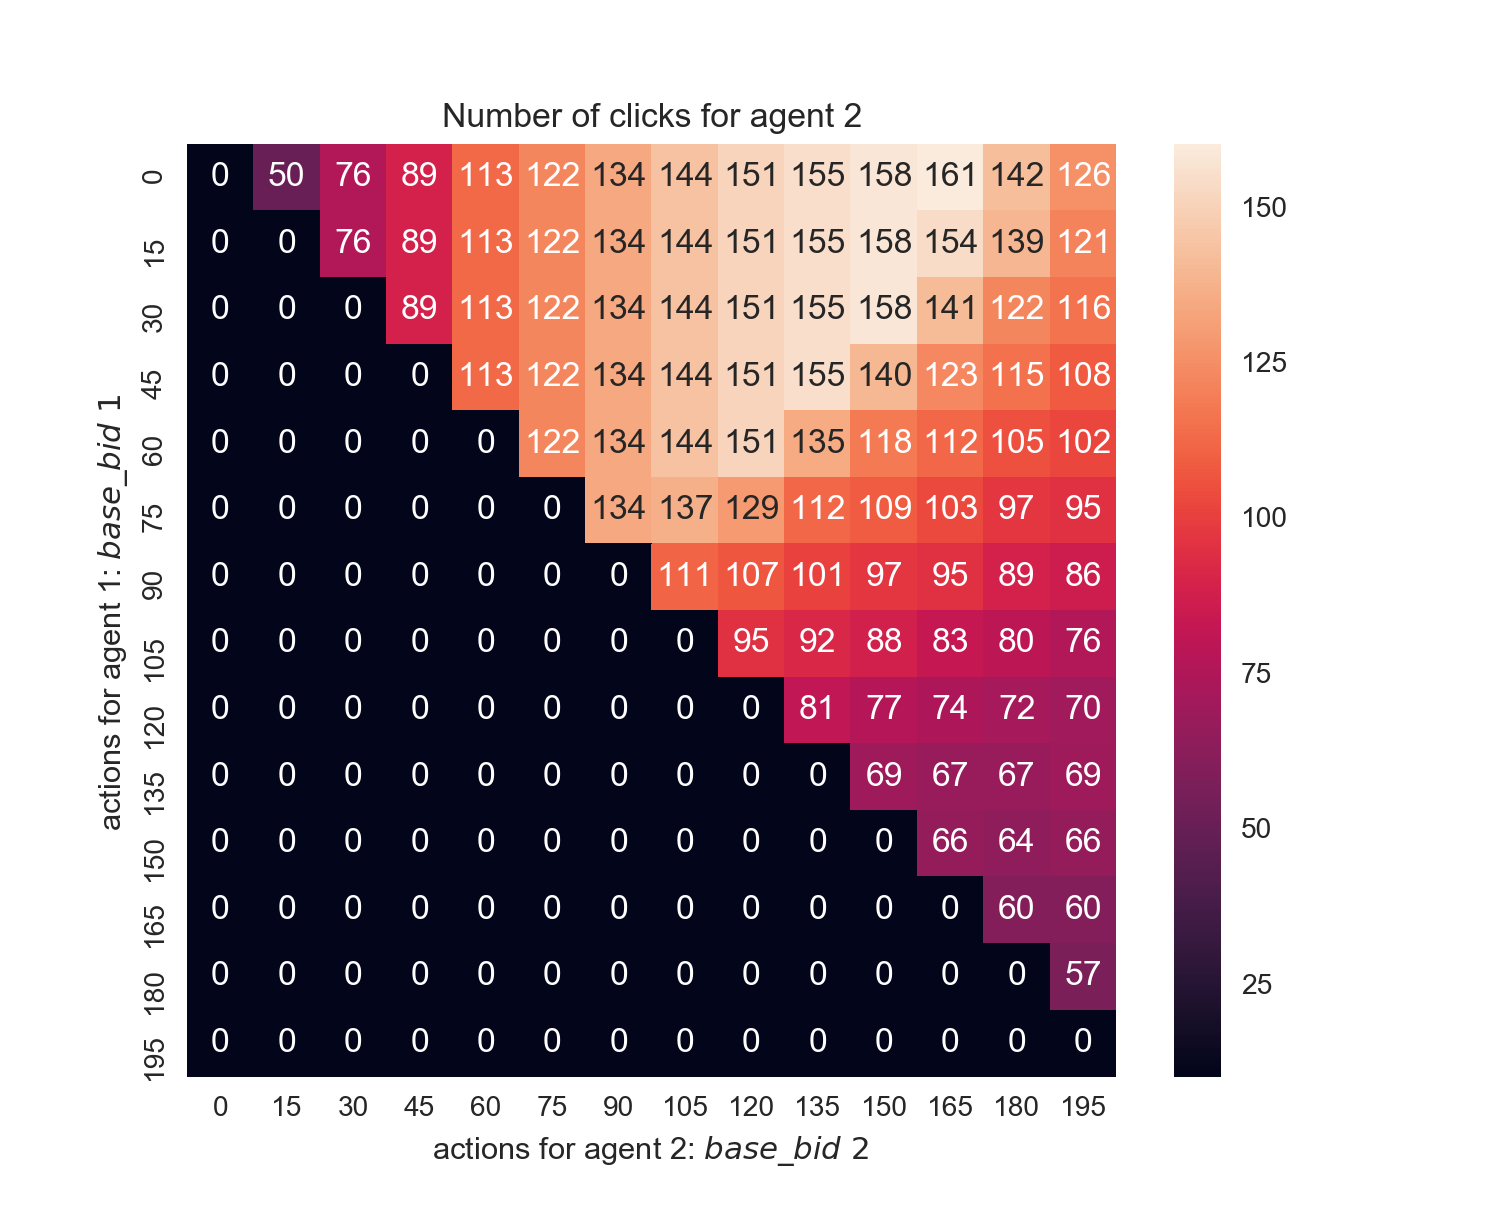

Text(52.7222,0.5,'actions for agent 1: $base\\_bid\\ 1$ ')

In [50]:
# plot
import seaborn as sns; sns.set()

fig = plt.figure()
ax = sns.heatmap(payoffs_agent2, annot=True, fmt="d", xticklabels=act1, yticklabels=act2, vmin=10, vmax=160)
plt.title('Number of clicks for agent 2')
plt.xlabel(r'actions for agent 2: $base\_bid\ 2$ ')
plt.ylabel(r'actions for agent 1: $base\_bid\ 1$ ')

In [28]:
#plt.savefig('two_agent_general.eps', bbox_inches='tight')
#plt.savefig('two_agent_general.svg', bbox_inches='tight')

### run experiment 2 

In [40]:
n_experiments = 1
exp_rnd = []

grids = 10
space1 = 5
space2 = 5
ini1 = 140
ini2 = 0
act1 = list(range(ini1, ini1 + grids*space1, space1))
act2 = list(range(ini2, ini2 + grids*space2, space2))

for i in tqdm(range(n_experiments)):
    #print(f'{i} / {n_experiments}')
    data_rand = data_new.sample(frac=1).reset_index(drop=True)
    exp_rnd.append(bi_agent(data_rand, act1, act2))

exp_rnd = np.array(exp_rnd)
exp_avg = np.mean(exp_rnd, axis = 0)

payoffs_agent1 = np.round(exp_avg[:,:,0]).astype(int)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:28<00:00, 28.24s/it]


<IPython.core.display.Javascript object>


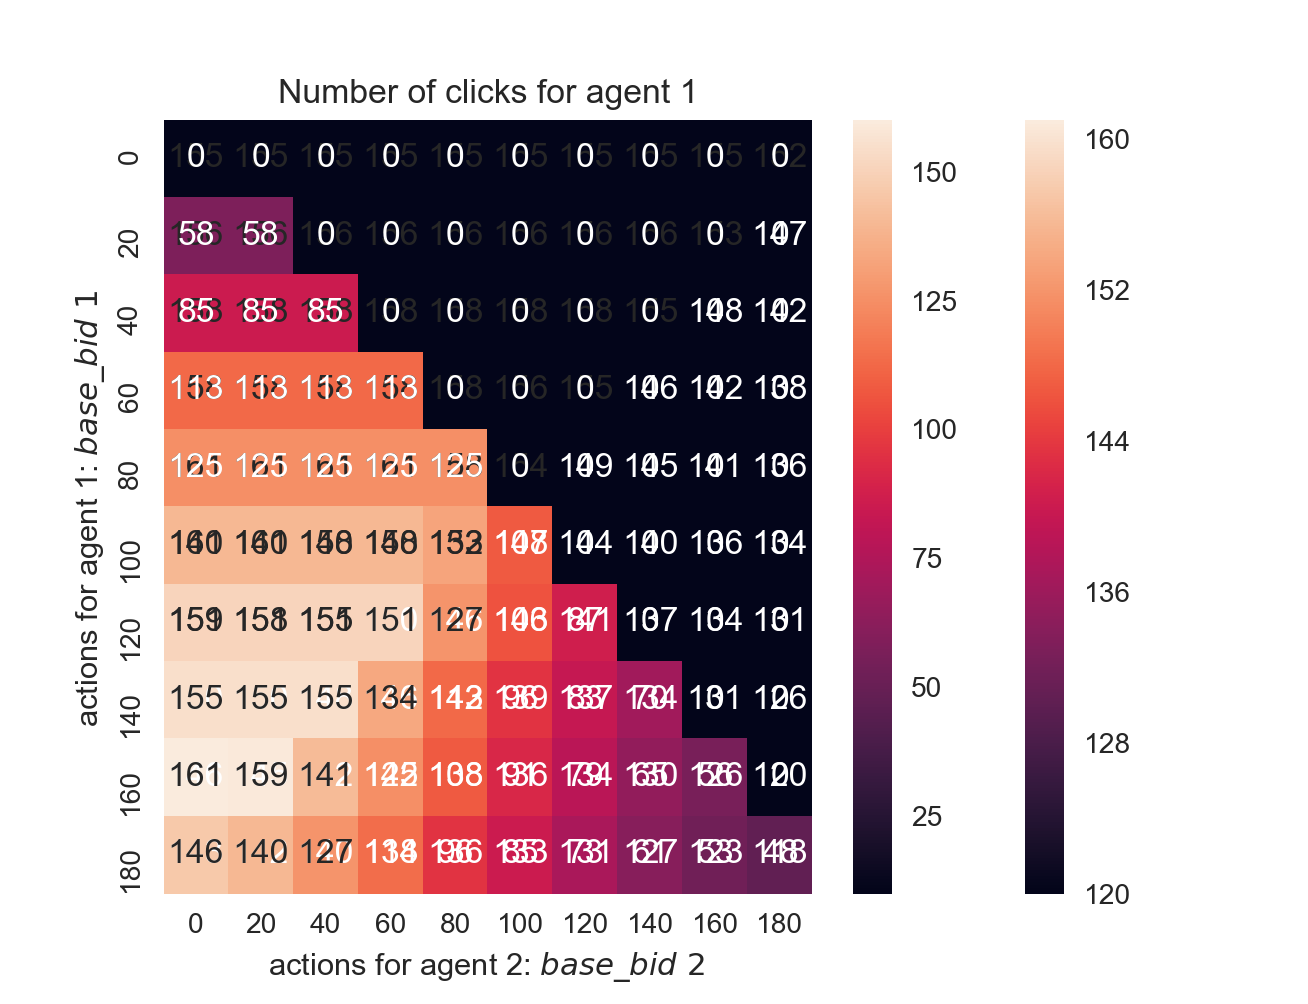

Text(52.7222,0.5,'actions for agent 1: $base\\_bid\\ 1$ ')

In [41]:
# plot
import seaborn as sns; sns.set()

plt.figure()
ax = sns.heatmap(payoffs_agent1, annot=True, fmt="d", xticklabels=act2, yticklabels=act1, vmin=120, vmax=161)
plt.title('Number of clicks for agent 1')
plt.xlabel(r'actions for agent 2: $base\_bid\ 2$')
plt.ylabel(r'actions for agent 1: $base\_bid\ 1$')

In [42]:
plt.savefig('two_agent_zoom.eps', bbox_inches='tight')
plt.savefig('two_agent_zoom.svg', bbox_inches='tight')

# EXTRA: check that everything is all right with hard-coded version

In [15]:
def bi_agent_hardcoded(dat, act1, act2):
    
    n = dat.shape[0]
    n_agents = 2
    
    n_act1 = len(act1)
    n_act2 = len(act2)
    
    results = []    
    payoffs = [[0]*n_act2 for _ in range(n_act1)]
    
    for ind1, b1 in enumerate(act1):
        for ind2, b2 in enumerate(act2):
            print(ind1, ind2)
            
            basebids = [b1, b2]
            bids = create_bids(basebids, dat)
            
            # case 1:
            # transaction 1: [1, 2] payprice = 3
            # nobody pays

            # case 2:
            # transaction 2: [1, 4] payprice = 3
            # player 2 pays 3

            # case 3:        
            # transaction 3: [4, 5] payprice = 3
            # player 2 pays 4
        
            budget1, budget2 = limited_budget, limited_budget 
            n_clks1, n_clks2 = 0, 0
            
            for itrans, payprice in enumerate(dat.payprice):
                
                bid1, bid2 = bids[itrans, :]
                maxbid = max(payprice, bid1, bid2)
                
                if maxbid == bid1 and budget1 > 0:
                    budget1 -= max(bid2, payprice)
                    n_clks1 += dat.click[itrans]
                elif maxbid == bid2 and budget2 > 0:
                    budget2 -= max(bid1, payprice)
                    n_clks2 += dat.click[itrans]
                

            payoffs[ind1][ind2] = [n_clks1, n_clks2]
            
    return payoffs

In [16]:
#run it
n_experiments = 1
exp_rnd = []

act1 = [110, 120, 130]
act2 = [110, 120, 130]

for i in range(n_experiments):
    data_rand = data_new
    #data_rand = data_new.sample(frac=1).reset_index(drop=True)
    exp_rnd.append(bi_agent_hardcoded(data_rand, act1, act2))

exp_rnd = np.array(exp_rnd).squeeze()
print(exp_rnd)
print(exp_rnd[:,:,0])
print(exp_rnd[:,:,1])



print(sum(data_rand.click))

0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2
[[[99 48]
  [ 0 93]
  [ 0 93]]

 [[93  0]
  [87 64]
  [ 0 83]]

 [[93  0]
  [83  0]
  [78 76]]]
[[99  0  0]
 [93 87  0]
 [93 83 78]]
[[48 93 93]
 [ 0 64 83]
 [ 0  0 76]]
202


### Single agent 

In [17]:
def single_agent_hardcoded(dat, act1):
    
    n = dat.shape[0]
    n_agents = 1
    
    n_act1 = len(act1)
    
    results = []    
    payoffs = [0]*n_act1
    
    for ind1, b1 in enumerate(act1):
        print(ind1)

        basebids = [b1]
        bids = create_bids(basebids, dat)

        # case 1:
        # transaction 1: [1, 2] payprice = 3
        # nobody pays

        # case 2:
        # transaction 2: [1, 4] payprice = 3
        # player 2 pays 3

        # case 3:        
        # transaction 3: [4, 5] payprice = 3
        # player 2 pays 4

        budget1 = limited_budget 
        n_clks1= 0

        for itrans, payprice in enumerate(dat.payprice):

            bid1 = bids[itrans]
            maxbid = max(payprice, bid1)

            if maxbid == bid1 and budget1 > 0:
                budget1 -= payprice
                n_clks1 += dat.click[itrans]

        payoffs[ind1] = [n_clks1]
            
    return payoffs

In [20]:
#run it
n_experiments = 1
exp_rnd = []

act1 = [130, 140, 150, 160, 170]

for i in range(n_experiments):
    data_rand = data_new
    exp_rnd.append(single_agent_hardcoded(data_rand, act1))

exp_rnd = np.array(exp_rnd).squeeze()
print(exp_rnd)
print(sum(data_rand.click))

0
1
2
3
4
[154 155 158 161 156]
202
